In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import galaxy_experiments_lib as galaxy_lib

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=1, max_galaxies=1, num_bands=5, num_images=50)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

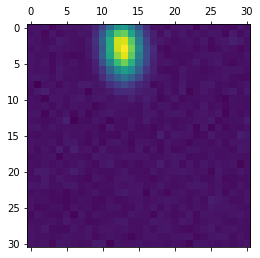

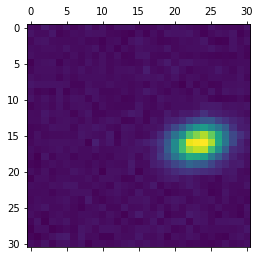

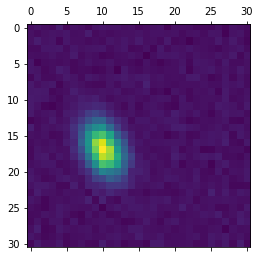

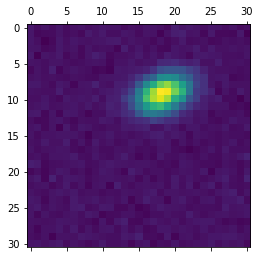

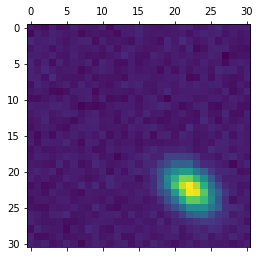

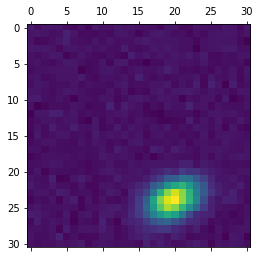

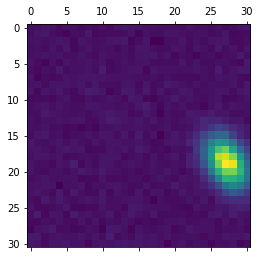

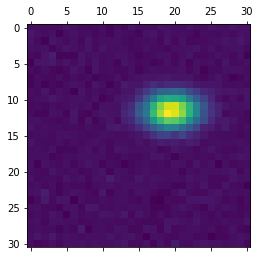

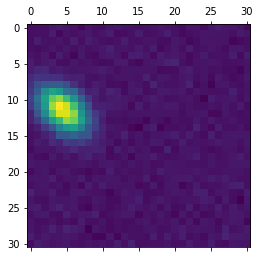

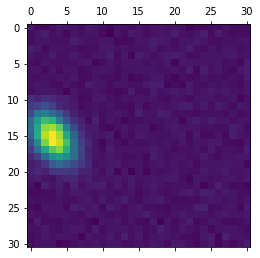

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
# The VAE
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [8]:
# state_dict = torch.load("./galaxy_vae.dat", map_location='cpu')
# # state_dict = torch.load("../galaxy_results/test_epoch80.dat", map_location='cpu')

# galaxy_vae.load_state_dict(state_dict, strict=False)

galaxy_vae.eval(); 

In [9]:
# torch.save(galaxy_vae.dec.state_dict(), '../galaxy_warm_starts/galaxy_dec_init.dat')

In [10]:
galaxy_rnn = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [11]:
pixel_probs = galaxy_rnn.get_pixel_probs(images_batch1, backgrounds_batch1)

In [12]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [13]:
cond_loss, recon_mean, recon_var = galaxy_rnn.get_loss_conditional_a(
                                            resid_image = images_batch1 - backgrounds_batch1, 
                                            image_so_far = backgrounds_batch1, 
                                            var_so_far = backgrounds_batch1, 
                                            pixel_1d = map_pixel_loc)

In [14]:
map_pixel_loc

tensor([ 529,  529,  529,  529,  529,  529,  529,  529,  529,  529])

In [15]:
recon_mean.sum()

tensor(3.3635e+07)

In [16]:
recon_var.sum()

tensor(3.3635e+07)

In [17]:
recon_mean

tensor([[[[ 700.,  700.,  700.,  ...,  700.,  700.,  700.],
          [ 700.,  700.,  700.,  ...,  700.,  700.,  700.],
          [ 700.,  700.,  700.,  ...,  700.,  700.,  700.],
          ...,
          [ 700.,  700.,  700.,  ...,  700.,  700.,  700.],
          [ 700.,  700.,  700.,  ...,  700.,  700.,  700.],
          [ 700.,  700.,  700.,  ...,  700.,  700.,  700.]],

         [[ 700.,  700.,  700.,  ...,  700.,  700.,  700.],
          [ 700.,  700.,  700.,  ...,  700.,  700.,  700.],
          [ 700.,  700.,  700.,  ...,  700.,  700.,  700.],
          ...,
          [ 700.,  700.,  700.,  ...,  700.,  700.,  700.],
          [ 700.,  700.,  700.,  ...,  700.,  700.,  700.],
          [ 700.,  700.,  700.,  ...,  700.,  700.,  700.]],

         [[ 700.,  700.,  700.,  ...,  700.,  700.,  700.],
          [ 700.,  700.,  700.,  ...,  700.,  700.,  700.],
          [ 700.,  700.,  700.,  ...,  700.,  700.,  700.],
          ...,
          [ 700.,  700.,  700.,  ...,  700.,  700.,

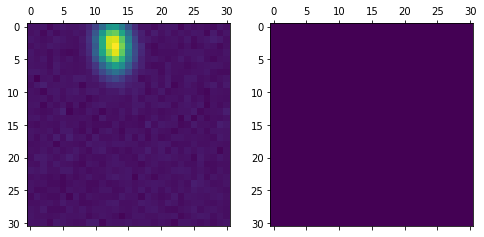

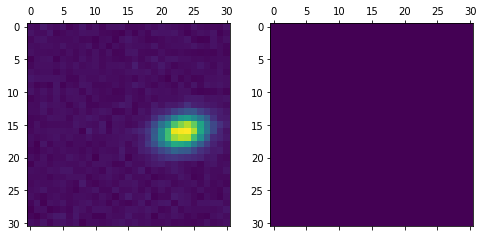

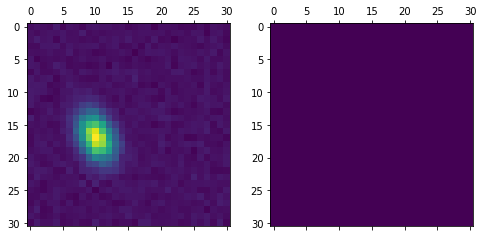

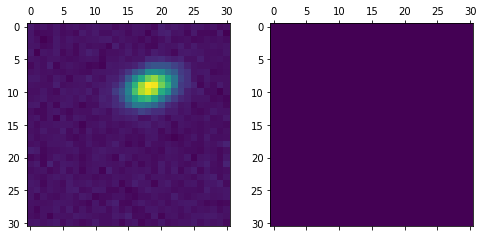

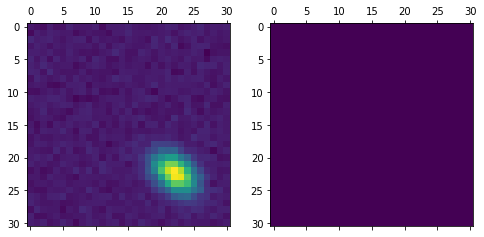

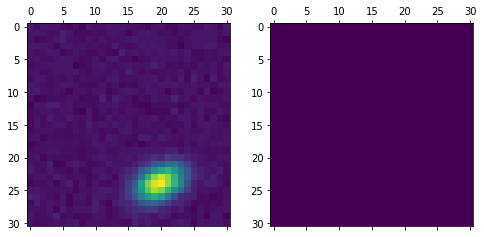

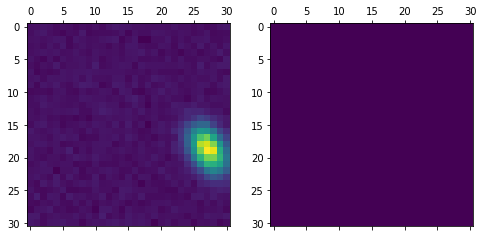

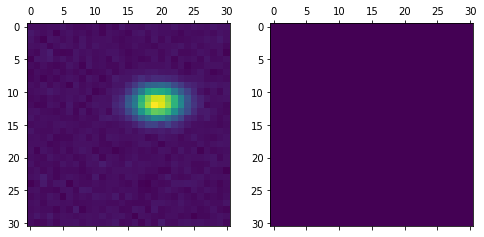

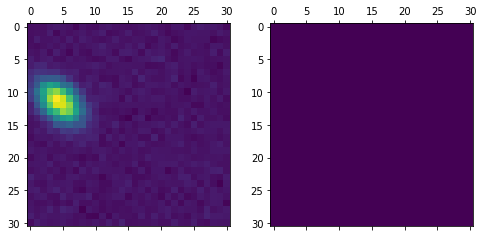

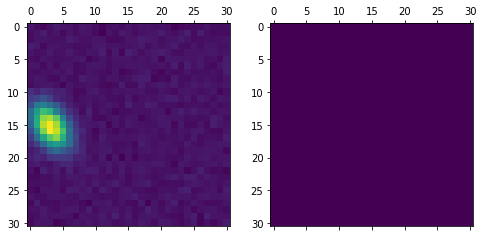

In [18]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())


In [19]:
# check optimizer goes through

In [20]:
optimizer = optim.Adam(galaxy_rnn.parameters(), lr=0.001, weight_decay=1e-6)
optimizer.zero_grad()

In [21]:
pm_loss, map_loss = galaxy_rnn.get_pm_loss(images_batch1, 
                                           backgrounds_batch1, 
                                           backgrounds_batch1, 
                                           alpha = 0.0, 
                                           topk = 5, 
                                           use_baseline = True)

In [22]:
map_loss

tensor(1.00000e+06 *
       4.1915)

In [23]:
pm_loss.backward()

In [24]:
optimizer.step()

In [25]:
_, map_loss2 = galaxy_rnn.get_pm_loss(images_batch1, 
                                           backgrounds_batch1, 
                                           backgrounds_batch1, 
                                           alpha = 0.0, 
                                           topk = 5, 
                                           use_baseline = True)

In [26]:
map_loss2

tensor(1.00000e+06 *
       4.1915)

In [27]:
# Check train module

In [28]:
galaxy_lib.train_module(galaxy_rnn, train_loader, test_loader, epochs = 12, save_every = 2, 
                        alpha = 0.0, topk = 0, use_baseline = True,
                        lr = 1e-4, weight_decay = 1e-6,
                        filename = './test',
                        seed = 245345)

[0] loss: 3557152  	[0.6 seconds]
  * test loss: 4537840
writing the network's parameters to ./test_epoch0.dat
[1] loss: 3474497  	[0.7 seconds]
[2] loss: 3192487  	[0.8 seconds]
  * test loss: 4456176
writing the network's parameters to ./test_epoch2.dat
[3] loss: 2905085  	[0.7 seconds]
[4] loss: 2725776  	[0.8 seconds]
  * test loss: 1553443
writing the network's parameters to ./test_epoch4.dat
[5] loss: 2941066  	[0.7 seconds]
[6] loss: 2649924  	[0.7 seconds]
  * test loss: 3825358
writing the network's parameters to ./test_epoch6.dat
[7] loss: 1948626  	[0.8 seconds]
[8] loss: 3046888  	[0.8 seconds]
  * test loss: 2298826
writing the network's parameters to ./test_epoch8.dat
[9] loss: 3563026  	[0.8 seconds]
[10] loss: 2631937  	[0.7 seconds]
  * test loss: 3582912
writing the network's parameters to ./test_epoch10.dat
[11] loss: 2609354  	[1.1 seconds]


In [29]:
# check we can load it back

galaxy_vae_reload = celeste_net.OneGalaxyVAE(side_len)
state_dict = torch.load("./test_epoch10.dat", map_location='cpu')
galaxy_vae_reload.load_state_dict(state_dict, strict=False)

galaxy_vae_reload.eval(); 

In [30]:
galaxy_vae_reload

OneGalaxyVAE(
  (attn_enc): PixelAttention(
    (attn): Sequential(
      (0): Conv2d(10, 7, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Conv2d(7, 1, kernel_size=(3, 3), stride=(1, 1))
      (7): Flatten()
      (8): Softmax()
    )
    (detect_none): Sequential(
      (0): Conv2d(10, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (8): Conv2d(16, 16, kernel_size=(3, 3), stri

In [31]:
np.load('./test_losses_array.npy')

array([4537839.5,       0. , 4456176. ,       0. , 1553443. ,       0. ,
       3825357.5,       0. , 2298826.5,       0. , 3582912.5,       0. ])